1. Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow. Importa la base de datos Customer Churn.csv y realiza el
preprocesamiento de los datos

In [14]:
#FernandoSanchez Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Input 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

#FernandoSanchez Cargar el archivo CSV
file_path = 'Customer Churn.csv'
data = pd.read_csv(file_path)

#FernandoSanchez Convertir variables categóricas a tipo 'category'
categorical_columns = ['Complains', 'Tariff Plan', 'Status', 'Churn']
data[categorical_columns] = data[categorical_columns].astype('category')

#FernandoSanchez Convertir variables categóricas a variables dummy
data = pd.get_dummies(data, drop_first=True)

#FernandoSanchez Separar las características y la variable objetivo
features = data.drop(columns='Churn_1')
target = data['Churn_1']

#FernandoSanchez Estandarizar las variables regresoras
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#FernandoSanchez Convertir de nuevo a un DataFrame para facilitar su manejo
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)


#FernandoSanchez Mostrar las primeras filas de las características estandarizadas
print(features_scaled_df.head())

#FernandoSanchez Confirmar que no hay valores nulos
print(features_scaled_df.isnull().sum())

   Call  Failure  Subscription  Length  Charge  Amount  Seconds of Use   
0       0.051229              0.636726       -0.619962       -0.024411  \
1      -1.050285              0.753384       -0.619962       -0.989807   
2       0.326608              0.520069       -0.619962       -0.481140   
3       0.326608              0.636726       -0.619962       -0.065390   
4      -0.637217              0.636726       -0.619962       -0.495435   

   Frequency of use  Frequency of SMS  Distinct Called Numbers  Age Group   
0          0.026816         -0.607513                -0.378158   0.194941  \
1         -1.122926         -0.589691                -1.133331  -0.925616   
2         -0.164807          2.547012                 0.028473   0.194941   
3         -0.060285         -0.643157                 0.667466  -2.046172   
4         -0.199648         -0.634246                 0.551285  -2.046172   

        Age  Customer Value  Complains_1  Tariff Plan_2  Status_2  
0 -0.113074       -0.528

2. Analiza la distribución de “Subscription Length” para cada clase (Churn),
describiendo si hay alguna incidencia de esta variable en la renuncia o no. Realiza
una estandarización de las variables regresoras

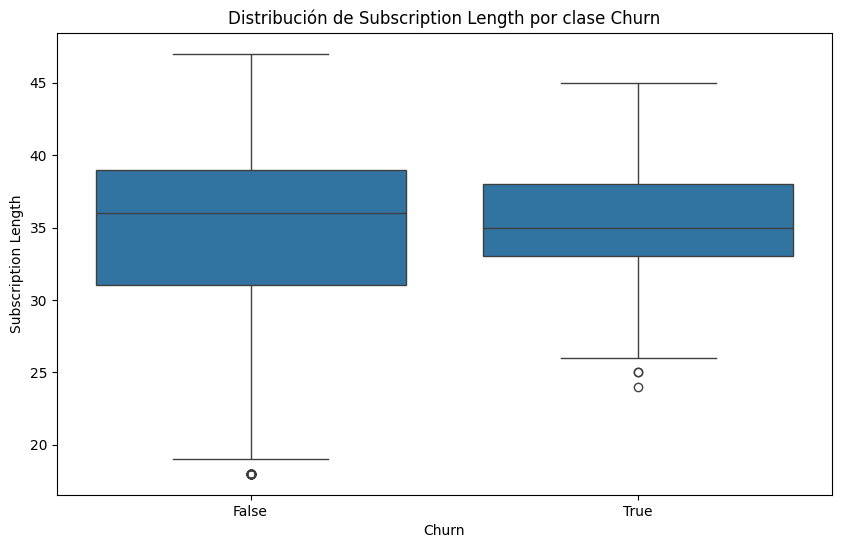

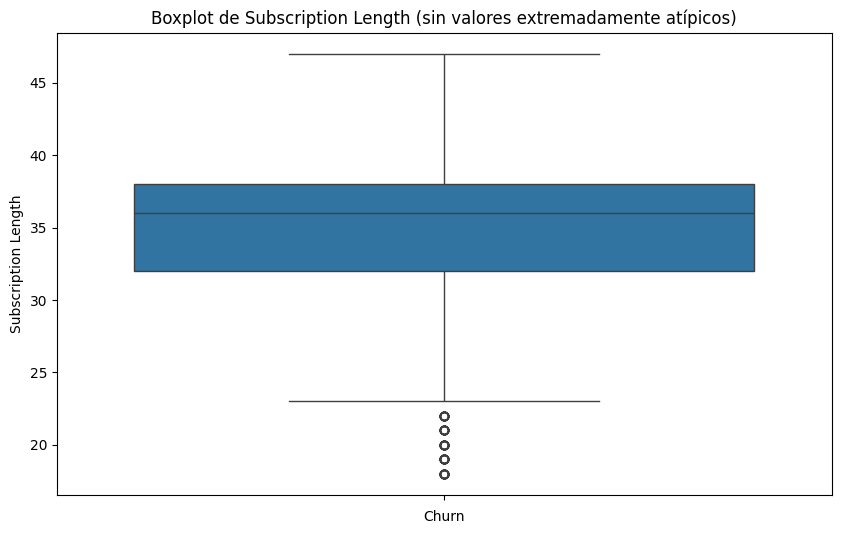

In [8]:
#FernandoSanchez Analizar la distribución de "Subscription Length" para cada clase
plt.figure(figsize=(10, 6))
sns.boxplot(x=target, y=data['Subscription  Length'])
plt.title('Distribución de Subscription Length por clase Churn')
plt.xlabel('Churn')
plt.ylabel('Subscription Length')
plt.show()

"""análisis sugiere que la duración de suscripción podría tener cierta influencia en la probabilidad de renuncia, 
con una mayor dispersión en los valores mínimos y la presencia de algunos valores atípicos."""

#FernandoSanchez Calcular el rango intercuartil (IQR)
Q1 = data['Subscription  Length'].quantile(0.25)
Q3 = data['Subscription  Length'].quantile(0.75)
IQR = Q3 - Q1

#FernandoSanchez Definir límites para valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#FernandoSanchez Filtrar datos fuera de los límites
filtered_data = data[(data['Subscription  Length'] >= lower_bound) & (data['Subscription  Length'] <= upper_bound)]

#FernandoSanchez Verificar la eliminación de valores atípicos
plt.figure(figsize=(10, 6))
sns.boxplot(y=filtered_data['Subscription  Length'])
plt.title('Boxplot de Subscription Length (sin valores extremadamente atípicos)')
plt.xlabel('Churn')
plt.ylabel('Subscription Length')
plt.show()

#FernandoSanchez Actualizar las características y la variable objetivo
features = filtered_data.drop(columns='Churn_1')
target = filtered_data['Churn_1']

#FernandoSanchez Estandarizar las variables regresoras
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#FernandoSanchez Convertir de nuevo a un DataFrame para facilitar su manejo
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

"""Se hace el tratamiento de valores atipicos eliminando aquellos extremadamente atipicos"""

3. Muestra la frecuencia de cada clase y realiza un balanceo de clase usando SMOTE.
Divida el conjunto de datos en entrenamiento y test, considerando para este último
un 33%.

In [10]:
#FernandoSanchez Mostrar la frecuencia de cada clase
print(target.value_counts())

#FernandoSanchez Balancear las clases usando SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(features_scaled_df, target)

#FernandoSanchez Dividir el conjunto de datos en entrenamiento y prueba (67% entrenamiento, 33% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

#FernandoSanchez Verificar el balanceo en los datos de entrenamiento
print(pd.Series(y_train).value_counts())


Churn_1
False    2436
True      432
Name: count, dtype: int64
Churn_1
True     1664
False    1600
Name: count, dtype: int64


4. Entrene un modelo RandomForest con hiper parámetros por defecto, usando el
conjunto de entrenamiento anterior y muestra la métrica F1-Score para ambas
clases en el conjunto de test. Captura y muestra las siete características más
importantes detectadas por el modelo RandomForest.

In [11]:
#FernandoSanchez Entrenar un modelo RandomForest con hiperparámetros por defecto
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#FernandoSanchez Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)

#FernandoSanchez Calcular la métrica F1-Score para ambas clases
f1score_churn_0 = f1_score(y_test, y_pred, pos_label=False)
f1score_churn_1 = f1_score(y_test, y_pred, pos_label=True)

print("F1-Score para la clase Churn_0:", f1score_churn_0)
print("F1-Score para la clase Churn_1:", f1score_churn_1)

#FernandoSanchez Obtener las siete características más importantes
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features_indices = sorted_indices[:7]
top_features = features.columns[top_features_indices]

print("Siete características más importantes:")
for feature in top_features:
    print(feature)

"""el modelo tiene una muy buena capacidad para predecir ambas clases.
Además, las siete características más importantes identificadas por el modelo son:

Status_2
Frequency of use
Seconds of Use
Customer Value
Complains_1
Subscription Length
Charge Amount"""

F1-Score para la clase Churn_0: 0.9691842900302114
F1-Score para la clase Churn_1: 0.9673286354900704
Siete características más importantes:
Status_2
Frequency of use
Seconds of Use
Customer Value
Complains_1
Subscription  Length
Charge  Amount


5. Usando las siete características encontradas anteriormente, filtra el conjunto de
entrenamiento y entrena un modelo de red neuronal feedforward con sólo una capa
oculta. Para esto debes definir una función de activación adecuada, tanto para la
capa oculta como para la capa de salida, la cantidad de neuronas a usar, la tasa de
aprendizaje (learning_rate), y la cantidad de épocas deben ser ajustadas
manualmente. Como optimizador, utiliza el Descenso del Gradiente Estocástico. Los
ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea
mayor al 90%. Muestra finalmente ROC y su AUC. (3 Puntos)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC: 0.9377107246448672


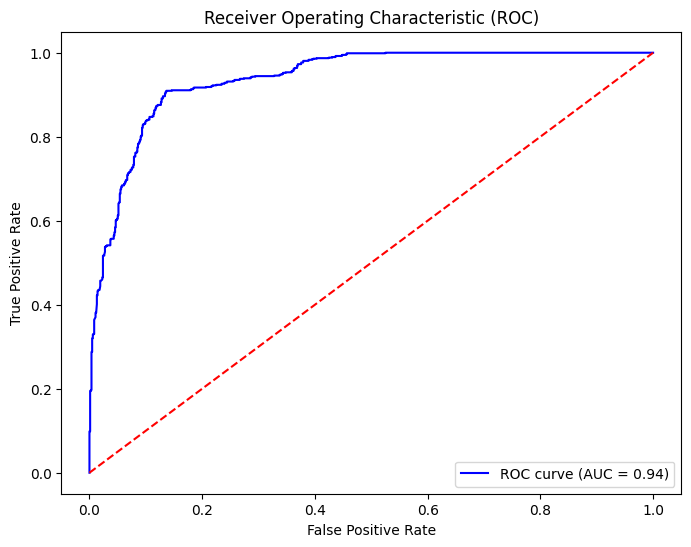

In [15]:
# Definir las siete características seleccionadas
selected_features = ['Status_2', 'Frequency of use', 'Seconds of Use', 'Customer Value', 'Complains_1', 'Subscription  Length', 'Charge  Amount']

# Filtrar el conjunto de entrenamiento utilizando las características seleccionadas
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

# Definir una función de activación adecuada
activation_hidden = 'relu'  # Seleccionar ReLU como función de activación para la capa oculta
activation_output = 'sigmoid'  # Seleccionar sigmoide como función de activación para la capa de salida

# Definir la cantidad de neuronas a usar en la capa oculta
neurons = 16  # Número de neuronas en la capa oculta

# Definir la tasa de aprendizaje (learning rate)
learning_rate = 0.01  # Seleccionar una tasa de aprendizaje

# Definir la cantidad de épocas
epochs = 50  # Seleccionar la cantidad de épocas

# Definir el modelo de red neuronal feedforward
model = Sequential([
    Input(shape=(len(selected_features),)),
    Dense(neurons, activation=activation_hidden),
    Dense(1, activation=activation_output)
])

# Compilar el modelo utilizando el Descenso del Gradiente Estocástico como optimizador
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

# Entrenar el modelo
history = model.fit(X_train_filtered, y_train, epochs=epochs, validation_split=0.2, verbose=0)

# Obtener las predicciones en el conjunto de prueba
y_pred_proba = model.predict(X_test_filtered)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

"""
El alto valor del AUC (0.938) y la forma de la curva ROC indican que el modelo de red neuronal feedforward tiene un desempeño excelente en la predicción de la retención de clientes. 
Esto significa que el modelo es muy efectivo para identificar correctamente a los clientes que renunciarán y a los que no renunciarán."""